In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [2]:
df = pd.read_csv("biogasdf_ready.csv", parse_dates=['date'])
df['Month'] = df['date'].dt.month
df['Hour'] = pd.to_datetime(df['hour'], format='%H:%M:%S').dt.hour

In [3]:
df.head()

,date,hour,fluid_temp,ground_temp,air_umidity,air_temp,gas_umidity,gas_temp,dm3_gas,bio_id,phase_test,Month,Hour
0,2021-08-10,22:48:53,14.81,14.69,66.7,18.8,84.50,16.93,0.0,1,0,8,22
1,2021-08-10,23:33:53,14.88,14.69,78.3,18.0,84.45,15.83,0.0,1,0,8,23
2,2021-08-11,00:03:55,14.88,14.69,83.2,17.4,84.35,15.22,0.0,1,0,8,0
3,2021-08-11,00:33:55,14.88,14.69,84.8,16.7,84.15,14.58,0.0,1,0,8,0
4,2021-08-11,00:48:54,14.88,14.69,87.4,16.0,84.10,14.18,0.0,1,0,8,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44003 entries, 0 to 44002
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         44003 non-null  datetime64[ns]
 1   hour         44003 non-null  object        
 2   fluid_temp   44003 non-null  float64       
 3   ground_temp  44003 non-null  float64       
 4   air_umidity  44003 non-null  float64       
 5   air_temp     44003 non-null  float64       
 6   gas_umidity  16336 non-null  float64       
 7   gas_temp     16341 non-null  float64       
 8   dm3_gas      44003 non-null  float64       
 9   bio_id       44003 non-null  int64         
 10  phase_test   44003 non-null  int64         
 11  Month        44003 non-null  int64         
 12  Hour         44003 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(4), object(1)
memory usage: 4.4+ MB


In [5]:
df['dm3_gas'].value_counts()

0.00    41268
0.01     2735
Name: dm3_gas, dtype: int64

From the value cout of dm3_gas, its notably that there are two classes of production either any gas was produced or not.

Therefore we categorise the two entries

In [6]:
#replacing the target values with 0 and 1

df['dm3_gas'].replace({0.00: 0, 0.01: 1}, inplace=True)

impute missing values

In [7]:
df = df.fillna(0)

In [8]:
df.head()

,date,hour,fluid_temp,ground_temp,air_umidity,air_temp,gas_umidity,gas_temp,dm3_gas,bio_id,phase_test,Month,Hour
0,2021-08-10,22:48:53,14.81,14.69,66.7,18.8,84.50,16.93,0.0,1,0,8,22
1,2021-08-10,23:33:53,14.88,14.69,78.3,18.0,84.45,15.83,0.0,1,0,8,23
2,2021-08-11,00:03:55,14.88,14.69,83.2,17.4,84.35,15.22,0.0,1,0,8,0
3,2021-08-11,00:33:55,14.88,14.69,84.8,16.7,84.15,14.58,0.0,1,0,8,0
4,2021-08-11,00:48:54,14.88,14.69,87.4,16.0,84.10,14.18,0.0,1,0,8,0


Checking for outliers

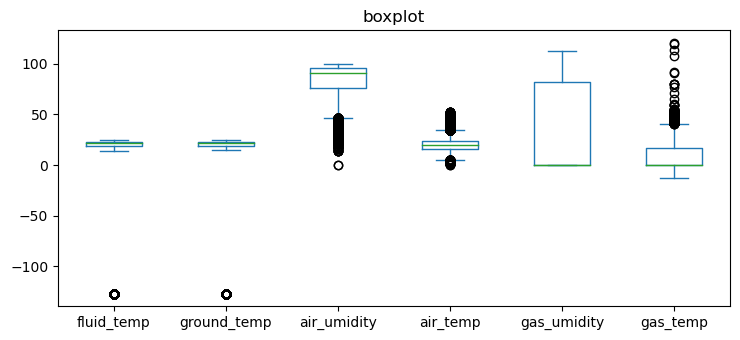

In [9]:
# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = df[['fluid_temp', 'ground_temp', 'air_umidity', 'air_temp', 'gas_umidity', 'gas_temp']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

## Train Test Split

In [10]:
X = df.drop(columns = ["dm3_gas", "date", "hour"], axis=1)

y = df['dm3_gas']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape,  y_train.shape, y_test.shape

((35202, 10), (8801, 10), (35202,), (8801,))

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

## Models

Fitting in the datset into different models and evaluate which performs better.

In [13]:
# Importing Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


#models
models = {
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42),
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(kernel='linear', C=1),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=3, random_state=42),
    "GaussianNB" : GaussianNB(),
    "KNeighborsClassifier" : KNeighborsClassifier()
}

# Fitting and printing the scores
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    print(f"{name}: {model.score(X_test_scaled, y_test)}")

RandomForestClassifier: 0.9352346324281332
LogisticRegression: 0.9352346324281332
SVC: 0.9352346324281332
DecisionTreeClassifier: 0.9352346324281332
GaussianNB: 0.7392341779343257
KNeighborsClassifier: 0.9239859106919668


Except for GaussianNB the models performed fairly well for classififcation problem

### Grid Search

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

grid_search_model = grid_search.fit(X_train_scaled, y_train)
grid_search.best_params_


KeyboardInterrupt



In [ ]:
grid_search_model.score(X_test_scaled, y_test)

## More Classifiers

In [ ]:
#Advanced models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


ad_models = {
    "BaggingClassifier" : BaggingClassifier(),
    "AdaBoostClassifier" : AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=42),
    "GradientBoostingClassifier" : GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
   
    
}


# Fitting and printing the scores
for name, model in ad_models.items():
    model.fit(X_train_scaled, y_train)
    print(f"{name}: {model.score(X_test_scaled, y_test)}")

## Random Forest

In [15]:
# Using Random Forest
rfc = RandomForestClassifier()

In [16]:
model = rfc.fit(X_train_scaled, y_train)

In [17]:
model.score(X_test_scaled, y_test)

0.9259175093739348

In [18]:
preds = model.predict(X_train_scaled)

In [19]:
df_pred = pd.DataFrame({'preds' : preds,
                        'Hour' : X_train.Hour,
                        'dm3' : y_train.values}
                )

In [20]:
# import joblib
# import os
# # Save the best model to a file
# joblib.dump(model, "rfc_model1.pkl")

['rfc_model1.pkl']

## Feature Importance

In [24]:
# dropping unnecessary features

X_feat_import = df.drop(columns = ["dm3_gas", "date", "hour", "dm3_gas", "bio_id",  "phase_test"], axis=1)
X_feat_import = X_feat_import.fillna(0)
y_feat_import = df['dm3_gas']


X_train_feat_import, X_test_feat_import,y_train_feat_import,  y_test_feat_import = train_test_split(X_feat_import, y_feat_import, test_size=0.2, random_state=42)
X_train_feat_import.shape, X_test_feat_import.shape,  y_train_feat_import.shape, y_test_feat_import.shape

((35202, 8), (8801, 8), (35202,), (8801,))

In [25]:
from sklearn.preprocessing import MinMaxScaler

feat_import_scaler = MinMaxScaler()
X_train_scaled_feat_import = pd.DataFrame(feat_import_scaler.fit_transform(X_train_feat_import))
X_test_scaled_feat_import = pd.DataFrame(feat_import_scaler.fit_transform(X_test_feat_import))


### 1.0 Logistic Regression;  feature weights

In [26]:
#Logistic Regression

lr = LogisticRegression()
lr_model = lr.fit(X_train_scaled_feat_import, y_train_feat_import)

#feature weights
feature_weights = lr_model.coef_

#Output
print("Coefficients for Features:", feature_weights)

Coefficients for Features: [[ 3.57233163  1.33566647  1.38289755 -0.59241841 -1.12949132  3.23235945
  -1.1073368   0.02842804]]


### 2.0 RandomForestClassifier;  fearture of importance

In [27]:
#RandomForest Classifier
rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train_scaled_feat_import, y_train_feat_import)

feature_importances = rfc_model.feature_importances_
print("Coefficients for Features:", feature_importances)

Coefficients for Features: [0.1315339  0.1144733  0.23912579 0.23696761 0.04701146 0.04621767
 0.05275886 0.13191142]


In [28]:
ranks = pd.DataFrame({ "features" : X_train_feat_import.columns,
    "rfc_features" : feature_importances,
                        "logist_features" : feature_weights.flatten()
                       })

## using lightgbm

In [29]:
import lightgbm as lgb
lgb =lgb.LGBMClassifier()
model = lgb.fit(X_train_scaled, y_train)
model.score(X_test_scaled, y_test)

[LightGBM] [Info] Number of positive: 2165, number of negative: 33037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 35202, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061502 -> initscore=-2.725208
[LightGBM] [Info] Start training from score -2.725208


0.9348937620724918

In [30]:
#pip install lightgbm

In [31]:
import numpy as np
import lightgbm as lgb

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X_train_feat_import.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [32]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X_train_feat_import, y_train_feat_import, test_size = 0.3, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y,  eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc')
    
    # Record the feature importances
    feature_importances += model.feature_importances_

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 1506, number of negative: 23135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 24641, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_samp

In [33]:
x = feature_importances / 2
lgb_feature_importances = pd.DataFrame({'feature': list(X_train_feat_import.columns), 
                                    'importance': feature_importances}).sort_values('importance', ascending = False)

lgb_feature_importances.head()

,feature,importance
3,air_temp,165326.0
2,air_umidity,159592.0
7,Hour,74523.0
0,fluid_temp,67914.0
1,ground_temp,63562.0


### Mutual information classifier

In [34]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(mutual_info_classif, k='all')
selector.fit(X_train_feat_import, y_train_feat_import)

mutual_feature_scores = selector.scores_
mutual_feature_scores

array([0.02858802, 0.02112903, 0.00865959, 0.00211919, 0.01247002,
       0.00729843, 0.03060286, 0.00342759])

In [35]:
mutual_features = pd.DataFrame({ "features" : X_train_feat_import.columns,
    "mutual_features" : mutual_feature_scores,
                       
                       }).sort_values('mutual_features', ascending = False)

### Chi-square

For Chi cannot feature entries which negatives another normalizer is used

In [36]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler()
X_train_scaledm = pd.DataFrame(mmscaler.fit_transform(X_train))
X_test_scaledm = pd.DataFrame(mmscaler.fit_transform(X_test))

In [37]:
#needs non-negative inputs

from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k='all')
selector.fit(X_train_scaled_feat_import, y_train_feat_import)

chi2_scores = selector.scores_
chi2_scores

array([  1.54187281,   0.72478957,   3.82818582,   0.34251763,
        90.44145761,   5.07467627, 119.33258845,   0.57301141])

In [38]:
chi_features = pd.DataFrame({ "features" : X_train_feat_import.columns,
    "chi_features" : chi2_scores,
                       
                       }).sort_values('chi_features', ascending = False)

## Ploting the different graphs


Below are plots for different selected features by different methods and models, They vary based on the criterias.

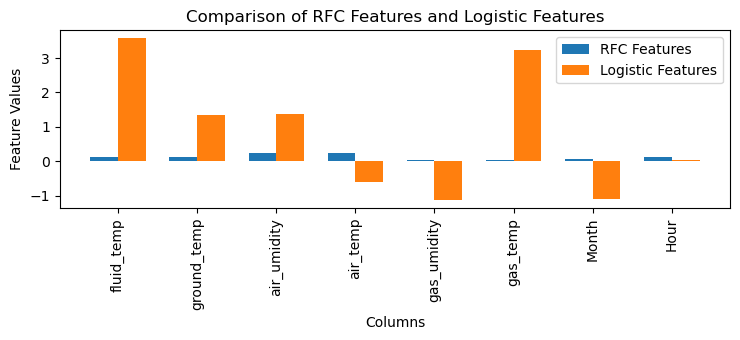

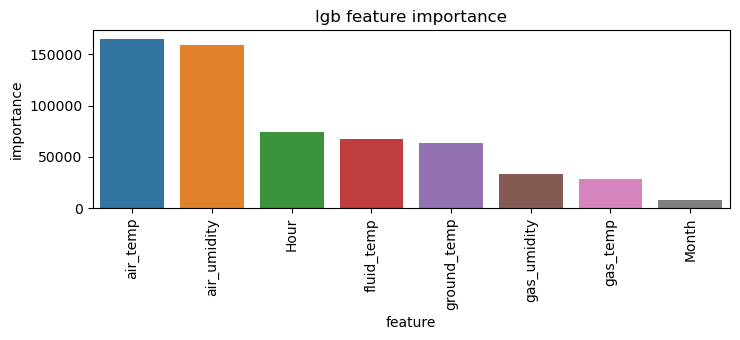

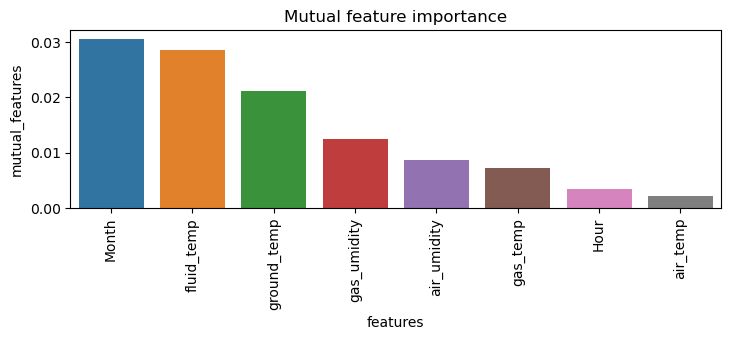

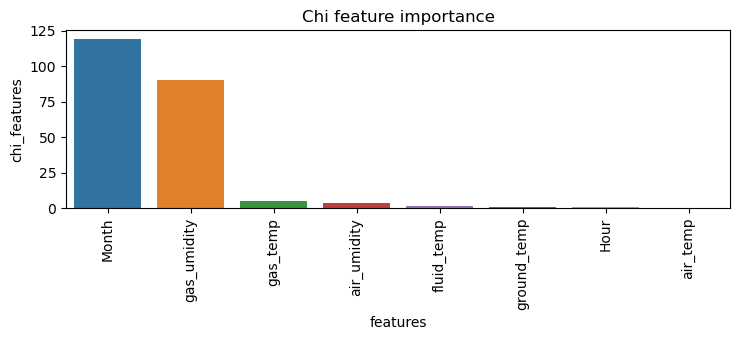

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots()

# Set the width of each bar
bar_width = 0.35

# Calculate the x positions for the bars
x = range(len(ranks['features']))

# Plot the bars for RFC features
ax.bar(x, ranks['rfc_features'], width=bar_width, label='RFC Features')

# Adjust x positions for the bars of Logistic Regression features
x = [i + bar_width for i in x]

# Plot the bars for Logistic Regression features
ax.bar(x, ranks['logist_features'], width=bar_width, label='Logistic Features')

# Set x-axis labels
ax.set_xticks([i + bar_width / 2 for i in range(len(ranks['features']))])
ax.set_xticklabels(ranks['features'], rotation=90)

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Columns')
ax.set_ylabel('Feature Values')
ax.set_title('Comparison of RFC Features and Logistic Features')

# Show the plot
plt.tight_layout()
plt.show()




# lightgbm features weights
sns.barplot(x="feature", y="importance", data=lgb_feature_importances)
plt.xticks(rotation=90)
plt.title("lgb feature importance")
plt.show()


# mutual features
sns.barplot(x="features", y="mutual_features", data=mutual_features)
plt.xticks(rotation=90)
plt.title("Mutual feature importance")
plt.show()


# Chi features
sns.barplot(x="features", y="chi_features", data=chi_features)
plt.xticks(rotation=90)
plt.title("Chi feature importance")
plt.show()

Gas Temperatures seems to have weights in most of the models

Considering Logistic regression (since its the most reliable in binary classifcation) selected features its evident that Fluid_temp and gas_temp carries more weight.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("biogasdf_ready.csv", parse_dates=['date'])
df['Month'] = df['date'].dt.month
df['Hour'] = pd.to_datetime(df['hour'], format='%H:%M:%S').dt.hour

In [ ]:
bio1_phase0 = df[(df['bio_id'] == 1) & (df['phase_test'] == 0)].reset_index()
bio1_phase1 = df[(df['bio_id'] == 1) & (df['phase_test'] == 1)].reset_index()
bio1_phase2 = df[(df['bio_id'] == 1) & (df['phase_test'] == 2)].reset_index()
bio1_phase3 = df[(df['bio_id'] == 1) & (df['phase_test'] == 3)].reset_index()
bio2_phase0 = df[(df['bio_id'] == 2) & (df['phase_test'] == 0)].reset_index()
bio2_phase1 = df[(df['bio_id'] == 2) & (df['phase_test'] == 1)].reset_index()
bio2_phase2 = df[(df['bio_id'] == 2) & (df['phase_test'] == 2)].reset_index()
bio2_phase3 = df[(df['bio_id'] == 2) & (df['phase_test'] == 3)].reset_index()

Compared to other set of datasets, bio1 phase2 has alittle more balanced

In [ ]:
df12 = bio1_phase2

In [ ]:
#replacing the target values with 0 and 1

df12['dm3_gas'].replace({0.00: 0, 0.01: 1}, inplace=True)

In [ ]:
df12.dm3_gas.value_counts()

In [ ]:
df12 = df12.fillna(0)

In [ ]:
df12.isnull().sum()

In [ ]:
df12.head(3)

In [ ]:
X_df12 = df12.drop(columns = ['dm3_gas','index', 'date', 'hour' ], axis=1)
y_df12 = df12['dm3_gas']

In [ ]:
X_train_df12, X_test_df12, y_train_df12, y_test_df12 = train_test_split(X_df12, y_df12, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_df12_scaled = scaler.fit_transform(X_train_df12)
X_test_df12_scaled = scaler.fit_transform(X_test_df12)

In [ ]:
#pip install --upgrade scikit-learn imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(X_train_df12_scaled, y_train_df12)

In [ ]:
X_resampled.shape, y_resampled.shape

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = rus.fit_resample(X_train_df12_scaled, y_train_df12)

In [ ]:
# Importing Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


#models
models = {
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42),
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(kernel='linear', C=1),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=3, random_state=42),
    "GaussianNB" : GaussianNB(),
    "KNeighborsClassifier" : KNeighborsClassifier()
}

# Fitting and printing the scores
for name, model in models.items():
    model.fit(X_train_df12_scaled, y_train_df12)
    print(f"{name}: {model.score(X_test_df12_scaled, y_test_df12)}")

### In the interest of making actual plot, using the actual data points to the gs production as well as line of best fit.

In [ ]:
slope1, intercept1 = np.polyfit(df12.fluid_temp, df12.ground_temp, 1)

#1.2 for the predicted values
#slope2, intercept2 = np.polyfit(X_train, y_train, 1)
# Create the regression line equations for both actual and predicted values
plt.figure(figsize=(8,5))
regression_line1 = slope1 * df12.fluid_temp + intercept1
#regression_line2 = slope2 * x + intercept2

# Plot the data points
plt.scatter(df12.fluid_temp, df12.ground_temp, c = df12.dm3_gas, label="Gas Production")
#plt.scatter(x, y_pred, label="Predicted Values")

# Plot the regression line
plt.plot(df12.fluid_temp, regression_line1, color='red', label="actual Linear Regression Line")
#plt.plot(x, regression_line2, color='green', label="predicted Linear Regression Line")


# Title, labels and a legend
plt.title("Gas production 0 & 1")
plt.xlabel("ground_temp")
plt.ylabel("fluid_temp")
#plt.xticks(np.arange(15,44,3))
plt.legend()
plt.grid()

# Show the plot
plt.show()

The bright dots shows points where gas production is happening.

In [ ]:
ranks = ranks.sort_values(by="logist_features", ascending=False)
plt.bar(ranks.features, ranks.logist_features)
plt.xticks(rotation=90)
plt.title("Logistic Feature importance")
plt.show()

In [ ]:
ranks = ranks.sort_values(by="rfc_features", ascending=False)
plt.bar(ranks.features, ranks.rfc_features)
plt.xticks(rotation=90)
plt.title("RandomForest Feature importance")
plt.show()